In [78]:
import pandas as pd

In [79]:


# Load the encounters data
df = pd.read_csv("data/encounters_details.csv")

# Load the adverse encounter IDs
adverse_series = pd.read_csv("data/adverse_events.csv", header=None, names=['encounter_id']).squeeze("columns")

# Load the providers data
providers_df = pd.read_csv("data/providers.csv")

# Load the employer data
employer_df = pd.read_csv("data/employer_in_network.csv")

# Convert adverse_series to a set for efficient lookup
adverse_set = set(adverse_series)

# Create 'adverse' column
df['adverse'] = df['encounter_id'].apply(lambda x: 1 if x in adverse_set else 0)

# Create a dictionary to map NPIs to employer_ids
npi_to_employer = {}
for _, row in employer_df.iterrows():
    employer_id = row['employer_id']
    npis_string = row['in_network_npis']
    npis = [int(npi.strip()) for npi in npis_string.split(',')]  # Split and convert to integers
    for npi in npis:
        if npi in npi_to_employer:
            npi_to_employer[npi].append(employer_id)
        else:
            npi_to_employer[npi] = [employer_id]


result_dict = {}

# Group by NPI and CPT
grouped = df.groupby(['npi', 'cpt'])

# Iterate through groups
for (npi, cpt), group in grouped:
    # Count 0s and 1s in the 'adverse' column for the current group
    counts = group['adverse'].value_counts()
    
    # Create the inner dictionary for the CPT code
    cpt_dict = {
        'OK': counts.get(0, 0),  # Default to 0 if 0 is not present
        'adverse': counts.get(1, 0)   # Default to 0 if 1 is not present
    }
    
    # Add to the NPI dictionary
    if npi not in result_dict:
        result_dict[npi] = {}
    result_dict[npi][cpt] = cpt_dict


# Calculate and add the 'total' key for each NPI based on 'paid_amount'
for npi in result_dict:
    total_paid = df[df['npi'] == npi]['paid_amount'].sum()
    result_dict[npi]['total'] = total_paid


# Add provider information to result_dict
for index, row in providers_df.iterrows():
    npi = row['npi']

    if pd.isna(npi):
        continue

    npi = int(npi)

    if npi in result_dict:
        provider_info = {
            'provider_name': row['provider_name'],
            'zip': int(row['zip']) if pd.notna(row['zip']) else 0  # Store zip as integer or 0 if NaN
        }
        result_dict[npi]['provider_info'] = provider_info
        # FIXED: Store employer ID in a specific key rather than replacing the entire dictionary
        result_dict[npi]['employer_id'] = npi_to_employer.get(npi, 0)


# Flatten all employer_ids in npi_to_employer and get unique set
all_employer_ids = set()
for employer_ids in npi_to_employer.values():
    if isinstance(employer_ids, list):
        all_employer_ids.update(employer_ids)
    else:
        all_employer_ids.add(employer_ids)
all_employer_ids = sorted(all_employer_ids)
        
data = []
for npi, cpt_data in result_dict.items():
    provider_name = cpt_data.get('provider_info', {}).get('provider_name')
    zip_code = cpt_data.get('provider_info', {}).get('zip', 0)
    dollar_sum = cpt_data.get('total', 0)
    
    # CPT-specific counts
    cpt_counts = {}
    for cpt, counts in cpt_data.items():
        if cpt not in ['provider_info', 'total', 'employer_id']:
            if isinstance(counts, dict):
                cpt_counts[f'{cpt}_ok'] = int(counts.get('OK', 0))
                cpt_counts[f'{cpt}_adverse'] = int(counts.get('adverse', 0))
            else:
                cpt_counts[f'{cpt}_ok'] = 0
                cpt_counts[f'{cpt}_adverse'] = 0

    # Employer binary columns
    npi_employers = cpt_data.get('employer_id', [])
    if not isinstance(npi_employers, list):
        npi_employers = [npi_employers]
    employer_binaries = {str(emp_id): (1 if emp_id in npi_employers else 0) for emp_id in all_employer_ids}

    # Combine all data for a single row
    row_data = {
        'NPI': npi,
        'provider_name': provider_name,      
        'zip': int(zip_code) if pd.notna(zip_code) else 0,
        'total_paid': int(dollar_sum),
        **cpt_counts,
        **employer_binaries  # Add employer columns
    }
    data.append(row_data)

# Create the DataFrame
final_df = pd.DataFrame(data)


# Print the DataFrame
print(final_df.head())




          NPI              provider_name        zip  total_paid  20610_ok  \
0  1063494227  Pedro-Alexander, Veronica  334113504      104144       2.0   
1  1073757183              Prasher, Anuj  349944512      819200       7.0   
2  1174543573             Husted, Daniel  349944512      220001       4.0   
3  1205818457          Montijo, Harvey E  334113504       99877       3.0   
4  1225221047                 Kam, Check  349944512      107604       2.0   

   20610_adverse  24538_ok  24538_adverse  27130_ok  27130_adverse  29806_ok  \
0            0.0         2              1         1              0       3.0   
1            0.0        31              0        37              6      19.0   
2            0.0         5              0        15              4       7.0   
3            0.0         4              0         2              3       3.0   
4            0.0         5              0         6              4       2.0   

   29806_adverse  29888_ok  29888_adverse  54011  69873 

In [81]:
cpt_codes = ['20610', '24538', '27130', '29806', '29888']

# Calculate success ratios for each CPT
for cpt in cpt_codes:
    ok_col = f'{cpt}_ok'
    adverse_col = f'{cpt}_adverse'
    
    # Check if columns exist in DataFrame
    if ok_col in final_df.columns and adverse_col in final_df.columns:
        # Calculate ratio with zero-division handling
        final_df[f'{cpt}_success_outcome'] = (
            final_df[ok_col] / 
            (final_df[ok_col] + final_df[adverse_col])
        ).fillna(0)  # Replace NaN with 0 if both counts are 0

# Show results
print(final_df.head())



          NPI              provider_name        zip  total_paid  20610_ok  \
0  1063494227  Pedro-Alexander, Veronica  334113504      104144       2.0   
1  1073757183              Prasher, Anuj  349944512      819200       7.0   
2  1174543573             Husted, Daniel  349944512      220001       4.0   
3  1205818457          Montijo, Harvey E  334113504       99877       3.0   
4  1225221047                 Kam, Check  349944512      107604       2.0   

   20610_adverse  24538_ok  24538_adverse  27130_ok  27130_adverse  ...  \
0            0.0         2              1         1              0  ...   
1            0.0        31              0        37              6  ...   
2            0.0         5              0        15              4  ...   
3            0.0         4              0         2              3  ...   
4            0.0         5              0         6              4  ...   

   29888_ok  29888_adverse  54011  69873  80914  20610_success_outcome  \
0         2 

In [101]:

# Prepare data for plotting
plot_data = pd.melt(
    final_df,
    id_vars=['NPI'],
    value_vars=[f'{cpt}_success_outcome' for cpt in cpt_codes],
    var_name='CPT_code',
    value_name='success_outcome'
)

# Clean up CPT_code to only show the code (remove '_success_outcome')
plot_data['CPT_code'] = plot_data['CPT_code'].str.replace('_success_outcome', '')

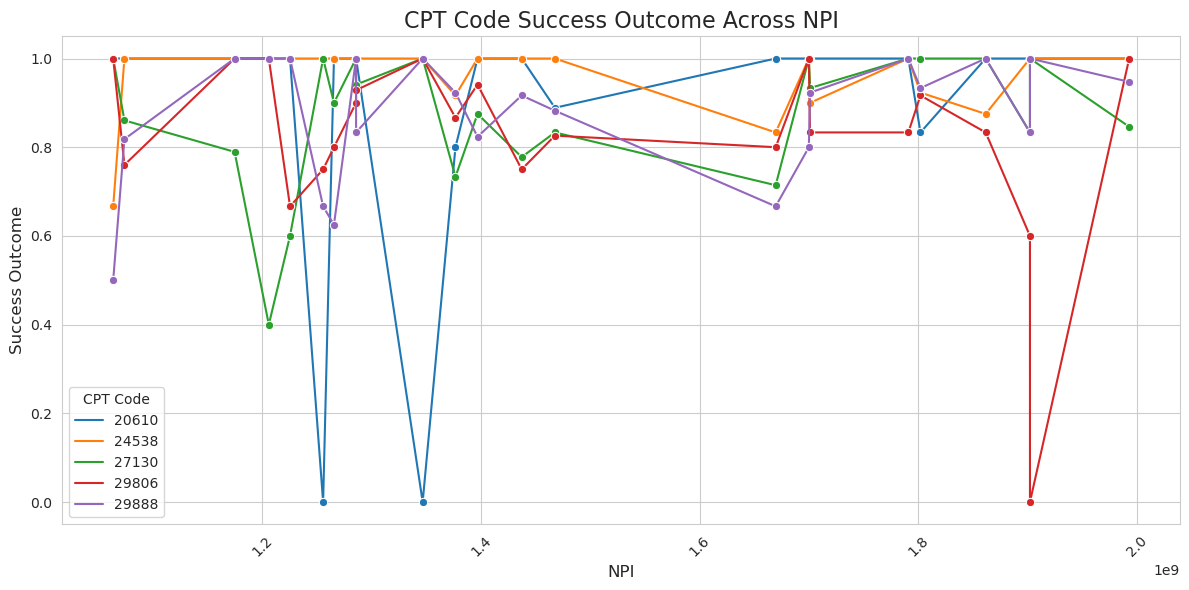

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=plot_data,
    x='NPI',
    y='success_outcome',
    hue='CPT_code',
    marker='o'
)
plt.title('CPT Code Success Outcome Across NPI', fontsize=16)
plt.xlabel('NPI', fontsize=12)
plt.ylabel('Success Outcome', fontsize=12)
plt.legend(title='CPT Code')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [83]:
import numpy as np

# Get all CPT codes from column names
cpt_codes = set()
for col in final_df.columns:
    if col.endswith('_ok'):
        cpt_codes.add(col[:-3])
cpt_codes = sorted(cpt_codes)

# Get all employer ids (assuming they are string columns of digits)
employer_cols = [col for col in final_df.columns if col.isdigit()]

rows = []
for _, row in final_df.iterrows():
    for cpt in cpt_codes:
        ok = row.get(f"{cpt}_ok", 0)
        adverse = row.get(f"{cpt}_adverse", 0)
        total = ok + adverse
        if total == 0:
            continue  # skip cases with no data
        success_rate = ok / total
        for emp_col in employer_cols:
            if row[emp_col] == 1:
                rows.append({
                    'CPT_code': cpt,
                    'employer_id': emp_col,
                    'success_rate': success_rate,
                    # Optionally add more features here
                })

ml_df = pd.DataFrame(rows)


In [84]:
from sklearn.preprocessing import LabelEncoder

# Encode CPT_code and employer_id as categorical variables
ml_df['CPT_code_enc'] = LabelEncoder().fit_transform(ml_df['CPT_code'])
ml_df['employer_id_enc'] = LabelEncoder().fit_transform(ml_df['employer_id'])


In [85]:
from sklearn.model_selection import train_test_split

X = ml_df[['CPT_code_enc', 'employer_id_enc']]
y = ml_df['success_rate'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [86]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [87]:

cpt_le = LabelEncoder().fit(ml_df['CPT_code'])
employer_le = LabelEncoder().fit(ml_df['employer_id'])

# Example: Predict for CPT code '29806' and employer id '54011'
cpt_code = '29806'
employer_id = '54011'

# Use the previously fitted LabelEncoders
cpt_code_enc = cpt_le.transform([cpt_code])[0]
employer_id_enc = employer_le.transform([employer_id])[0]

# Get the feature names from your training data
feature_names = X_train.columns

# Create a DataFrame for prediction with the correct feature names
X_new = pd.DataFrame([[cpt_code_enc, employer_id_enc]], columns=feature_names)

# Predict the success score
success_score = model.predict(X_new)[0]
print(f"Predicted success score: {success_score:.2f}")

Predicted success score: 0.81


In [88]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

MSE: 0.05026071090023968
R2: -0.10511076850952494


In [89]:

# Select top 5 CPT codes and employer IDs for demonstration
top_cpts = ml_df['CPT_code'].value_counts().index[:5]
top_employers = ml_df['employer_id'].value_counts().index[:5]

predictions = []

for cpt in top_cpts:
    for emp in top_employers:
        cpt_code_enc = cpt_le.transform([cpt])[0]
        employer_id_enc = employer_le.transform([emp])[0]
        X_new = pd.DataFrame([[cpt_code_enc, employer_id_enc]], columns=X_train.columns)
        pred_score = model.predict(X_new)[0]
        predictions.append({
            'CPT_code': cpt,
            'employer_id': emp,
            'predicted_success_score': pred_score
        })

pred_df = pd.DataFrame(predictions)


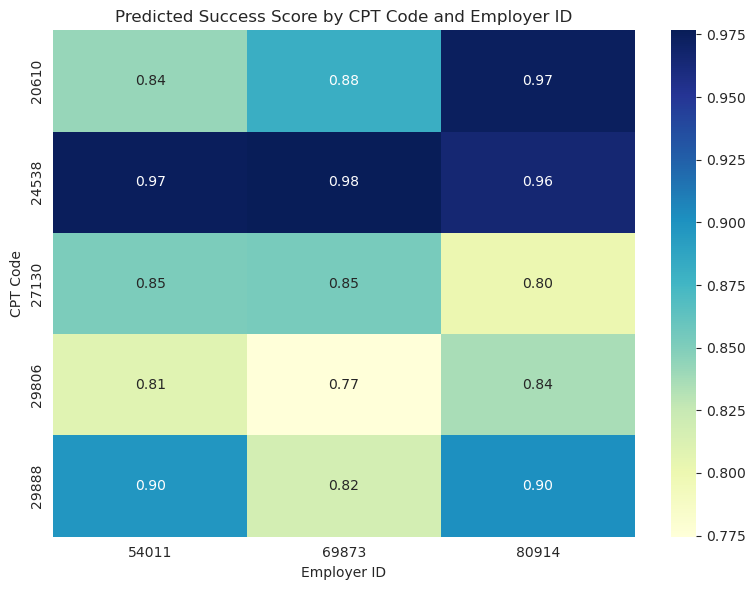

In [90]:
# Pivot the DataFrame for heatmap plotting
heatmap_data = pred_df.pivot(index='CPT_code', columns='employer_id', values='predicted_success_score')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Predicted Success Score by CPT Code and Employer ID")
plt.xlabel("Employer ID")
plt.ylabel("CPT Code")
plt.tight_layout()
plt.show()